In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from ipywidgets import interact
from scipy.optimize import curve_fit
from matplotlib import patches
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.metrics import peak_signal_noise_ratio as psnr

from datafusion.ffusion import FusionAdam
from datafusion.baseline import baseline
from datafusion.utils import mono_exponential_decay_numpy as decay
from datafusion.utils import (
    RESOURCES_PATH,
    FIGURES_PATH,
    spectral_volume_to_color,
    time_volume_to_lifetime,
    linear_to_srgb,
    wavelength_to_srgb,
    sam,
)

XY_DIM = 128
Z_START = 9
Z_END = 10

CELLS_PATH = RESOURCES_PATH / "cells.npz"
CELLS_ZOOM_PATH = RESOURCES_PATH / "cells_zoom.npz"

TAU = r"$\tau$"

In [50]:
cells = np.load(CELLS_PATH)
cells_zoom = np.load(CELLS_ZOOM_PATH)

# CMOS loading
cmos = cells["cmos"]
cmos = np.transpose(cmos, (1, 2, 0))
cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
cmos = np.transpose(cmos, (2, 1, 0))
cmos = cmos[Z_START:Z_END]

# SPC loading
spc = cells["spc"]
gt_spc = cells_zoom["spc"]
# FIXME: Replace with correct [0,0] pixel.
gt_spc[:, :, 0, 0] = gt_spc[:, :, 1, 0]

# Time axis loading
t = cells["time_axis"]
dt = t[1] - t[0]

# Wavelength axis loading
lam = cells["spectral_axis"]

metadata = cells["metadata"]
print(metadata)

[['laser' '520nm']
 ['dichroic' '550nm']
 ['filter' '550nm']
 ['spectrometer' '610nm']
 ['time_bin_size' '200ps']
 ['time_axis' 'ns']
 ['spectral_axis' 'nm']
 ['compression_ratio' '0.5']
 ['inversion' 'TVAL3_b5m8']
 ['time_cut' 'at peak']
 ['slide_info' 'Mouse Kidney F24630 FluoCells Invitrogen']]


In [51]:
initial_spectrums = np.sum(spc, axis=0)
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.sum(spc, axis=1)
min_times, max_times = np.min(initial_times), np.max(initial_times)

resolution_diff_factor = int(cmos.shape[-1] / spc.shape[-1])
normalized_cmos = cmos / cmos.max()

def spc_spectrum_time_in_a_point(cmos_z=5, spc_i=19, spc_j=17):
    _, ax = plt.subplots(2, 3, figsize=(9, 6))
    ax[0, 0].imshow(normalized_cmos[cmos_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].scatter([spc_j * resolution_diff_factor], [spc_i * resolution_diff_factor], c="w")
    ax[0, 0].set_title(f"CMOS in Z={cmos_z}")

    ax[1, 0].imshow(spectral_volume_to_color(lam, spc.sum(axis=0)[:, np.newaxis])[0])
    ax[1, 0].scatter([spc_j], [spc_i], c="w")
    ax[1, 0].set_title(f"SPC Spectrum Colored")

    ax[0, 1].plot(lam, spc.sum(axis=(0, 2, 3)))
    ax[0, 1].set_title(f"Global spectrum - {len(lam)} channels")
    ax[0, 1].set_xlabel("Wavelength [nm]")
    ax[0, 1].grid()

    ax[0, 2].plot(t, spc.sum(axis=(1, 2, 3)))
    ax[0, 2].set_title(f"Global time decay - {len(t)} temporal points")
    ax[0, 2].set_xlabel("Time [ns]")
    ax[0, 2].grid()

    ax[1, 1].plot(lam, initial_spectrums[:, spc_i, spc_j])
    ax[1, 1].set_ylim(min_spectrums, max_spectrums)
    ax[1, 1].set_title(f"Spectrum in ({spc_i},{spc_j})")
    ax[1, 1].set_xlabel("Wavelength [nm]")
    ax[1, 1].grid()

    ax[1, 2].plot(t, initial_times[:, spc_i, spc_j])
    ax[1, 2].set_ylim(min_times, max_times)
    ax[1, 2].set_title(f"Time in ({spc_i},{spc_j})")
    ax[1, 2].set_xlabel("Time [ns]")
    ax[1, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    cmos_z=(0, cmos.shape[0] - 1, 1),
    spc_i=(0, spc.shape[-2] - 1, 1),
    spc_j=(0, spc.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='cmos_z', max=0), IntSlider(value=19, description='spc_i'…

In [109]:
weights = {
    "spatial": 1.0,
    "lambda_time": 0.5,
    # "global": 0.0,
}

fusion = FusionAdam(
    spc, cmos,
    time_axis=t,
    weights=weights,
    init_type="simple",
    mask_noise=True,
    tol=1e-6,
    total_energy=1,
    device="mps",
    seed=42,
)

x, spc_out, cmos_out, x_fitted = fusion(max_iterations=800, lr=5e-2, return_numpy=True)

  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

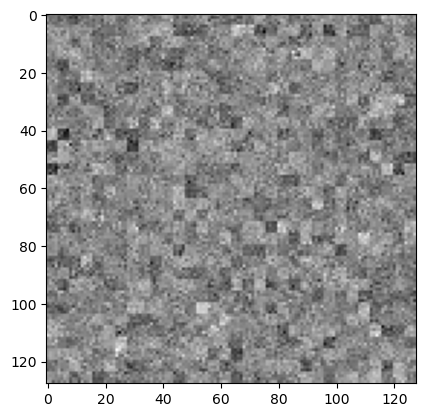

In [108]:
plt.imshow(x.sum(axis=(0, 1, 2)), cmap="gray")

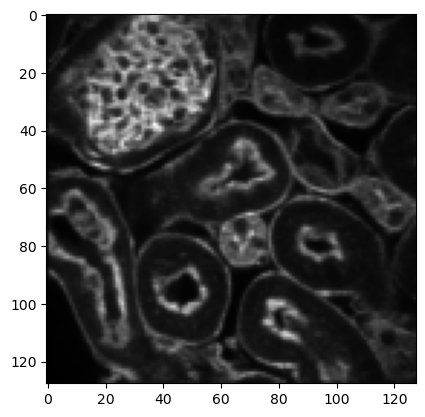

In [13]:
plt.imshow(cmos_out.sum(axis=0), cmap="gray")
